In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


import lovely_tensors as lt
lt.monkey_patch()

from tqdm.auto import tqdm

In [2]:
device = 'cuda:1'

# Data

In [3]:
! pip install scikit-video

In [ ]:
import skvideo.datasets

video_path = skvideo.datasets.bikes()

In [6]:
video_path

'/opt/conda/lib/python3.7/site-packages/skvideo/datasets/data/bikes.mp4'

In [7]:
from torch.utils.data import Dataset
import skvideo.io

In [8]:
class Video(Dataset):
    def __init__(self, path_to_video):
        super().__init__()
        if 'npy' in path_to_video:
            self.vid = np.load(path_to_video)
        elif 'mp4' in path_to_video:
            self.vid = skvideo.io.vread(path_to_video).astype(np.single) / 255.
            self.vid = self.vid[:10]
            

        self.shape = self.vid.shape[:-1]
        self.channels = self.vid.shape[-1]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.vid

In [9]:
vid_dataset = Video(video_path)
video = vid_dataset[0]
video.shape

(10, 272, 640, 3)

In [10]:
vid_dataset.vid[:10].shape

(10, 272, 640, 3)

In [11]:
vid_dataset

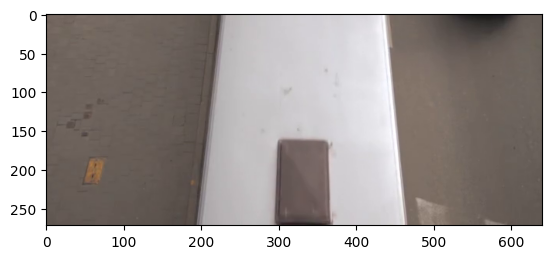

In [12]:
plt.imshow(video[9])

In [13]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)

    if dim == 2:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1]], axis=-1)[None, ...].astype(np.float32)
        pixel_coords[0, :, :, 0] = pixel_coords[0, :, :, 0] / (sidelen[0] - 1)
        pixel_coords[0, :, :, 1] = pixel_coords[0, :, :, 1] / (sidelen[1] - 1)
    elif dim == 3:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1], :sidelen[2]], axis=-1)[None, ...].astype(np.float32)
        pixel_coords[..., 0] = pixel_coords[..., 0] / max(sidelen[0] - 1, 1)
        pixel_coords[..., 1] = pixel_coords[..., 1] / (sidelen[1] - 1)
        pixel_coords[..., 2] = pixel_coords[..., 2] / (sidelen[2] - 1)
    else:
        raise NotImplementedError('Not implemented for dim=%d' % dim)

    pixel_coords -= 0.5
    pixel_coords *= 2.
    pixel_coords = torch.Tensor(pixel_coords).view(-1, dim)
    return pixel_coords

In [14]:
class Implicit3DWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, sidelength=None, sample_fraction=1.):

        if isinstance(sidelength, int):
            sidelength = 3 * (sidelength,)

        self.dataset = dataset
        self.mgrid = get_mgrid(sidelength, dim=3)
        data = (torch.from_numpy(self.dataset[0]) - 0.5) / 0.5
        self.data = data.view(-1, self.dataset.channels)
        self.sample_fraction = sample_fraction
        self.N_samples = int(self.sample_fraction * self.mgrid.shape[0])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.sample_fraction < 1.:
            coord_idx = torch.randint(0, self.data.shape[0], (self.N_samples,))
            data = self.data[coord_idx, :]
            coords = self.mgrid[coord_idx, :]
        else:
            coords = self.mgrid
            data = self.data

        in_dict = {'idx': idx, 'coords': coords}
        gt_dict = {'img': data}

        return in_dict, gt_dict

In [15]:
get_mgrid(vid_dataset.shape, 3)

tensor[1740800, 3] n=5222400 x∈[-1.000, 1.000] μ=2.440e-08 σ=0.599

In [16]:
coord_dataset = Implicit3DWrapper(vid_dataset, sidelength=vid_dataset.shape, sample_fraction=.1)

In [17]:
coord_dataset.data

tensor[1740800, 3] n=5222400 x∈[-0.835, 1.000] μ=0.054 σ=0.405

In [18]:
coord_dataset[0]

({'idx': 0,
  'coords': tensor[174080, 3] n=522240 x∈[-1.000, 1.000] μ=0.000 σ=0.599},
 {'img': tensor[174080, 3] n=522240 x∈[-0.835, 1.000] μ=0.053 σ=0.405})

In [19]:
video.shape

(10, 272, 640, 3)

In [20]:
# ! pip install torchmeta

In [21]:
class ImageDownsampling(nn.Module):
    '''Generate samples in u,v plane according to downsampling blur kernel'''

    def __init__(self, sidelength, downsample=False):
        super().__init__()
        if isinstance(sidelength, int):
            self.sidelength = (sidelength, sidelength)
        else:
            self.sidelength = sidelength

        if self.sidelength is not None:
            self.sidelength = torch.Tensor(self.sidelength).to(device).float()
        else:
            assert downsample is False
        self.downsample = downsample

    def forward(self, coords):
        if self.downsample:
            return coords + self.forward_bilinear(coords)
        else:
            return coords

    def forward_box(self, coords):
        return 2 * (torch.rand_like(coords) - 0.5) / self.sidelength

    def forward_bilinear(self, coords):
        Y = torch.sqrt(torch.rand_like(coords)) - 1
        Z = 1 - torch.sqrt(torch.rand_like(coords))
        b = torch.rand_like(coords) < 0.5

        Q = (b * Y + ~b * Z) / self.sidelength
        return Q


In [22]:

def sine_init(m):
    with torch.no_grad():
        if hasattr(m, 'weight'):
            num_input = m.weight.size(-1)
            # See supplement Sec. 1.5 for discussion of factor 30
            m.weight.uniform_(-np.sqrt(6 / num_input) / 30, np.sqrt(6 / num_input) / 30)


def first_layer_sine_init(m):
    with torch.no_grad():
        if hasattr(m, 'weight'):
            num_input = m.weight.size(-1)
            # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of factor 30
            m.weight.uniform_(-1 / num_input, 1 / num_input)


In [23]:
def init_weights_normal(m):
    if type(m) == BatchLinear or type(m) == nn.Linear:
        if hasattr(m, 'weight'):
            nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')


def init_weights_selu(m):
    if type(m) == BatchLinear or type(m) == nn.Linear:
        if hasattr(m, 'weight'):
            num_input = m.weight.size(-1)
            nn.init.normal_(m.weight, std=1 / math.sqrt(num_input))


def init_weights_elu(m):
    if type(m) == BatchLinear or type(m) == nn.Linear:
        if hasattr(m, 'weight'):
            num_input = m.weight.size(-1)
            nn.init.normal_(m.weight, std=math.sqrt(1.5505188080679277) / math.sqrt(num_input))


def init_weights_xavier(m):
    if type(m) == BatchLinear or type(m) == nn.Linear:
        if hasattr(m, 'weight'):
            nn.init.xavier_normal_(m.weight)

In [24]:
import torch
from torch import nn
from torchmeta.modules import (MetaModule, MetaSequential)
import numpy as np
from collections import OrderedDict
import math
import torch.nn.functional as F


class BatchLinear(nn.Linear, MetaModule):
    '''A linear meta-layer that can deal with batched weight matrices and biases, as for instance output by a
    hypernetwork.'''
    __doc__ = nn.Linear.__doc__

    def forward(self, input, params=None):
        if params is None:
            params = OrderedDict(self.named_parameters())

        bias = params.get('bias', None)
        weight = params['weight']

        output = input.matmul(weight.permute(*[i for i in range(len(weight.shape) - 2)], -1, -2))
        output += bias.unsqueeze(-2)
        return output


class Sine(nn.Module):
    def __init(self):
        super().__init__()

    def forward(self, input):
        # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of factor 30
        return torch.sin(30 * input)


class FCBlock(MetaModule):
    '''A fully connected neural network that also allows swapping out the weights when used with a hypernetwork.
    Can be used just as a normal neural network though, as well.
    '''

    def __init__(self, in_features, out_features, num_hidden_layers, hidden_features,
                 outermost_linear=False, nonlinearity='relu', weight_init=None):
        super().__init__()

        self.first_layer_init = None

        # Dictionary that maps nonlinearity name to the respective function, initialization, and, if applicable,
        # special first-layer initialization scheme
        nls_and_inits = {'sine':(Sine(), sine_init, first_layer_sine_init),
                         'relu':(nn.ReLU(inplace=True), init_weights_normal, None),
                         'sigmoid':(nn.Sigmoid(), init_weights_xavier, None),
                         'tanh':(nn.Tanh(), init_weights_xavier, None),
                         'selu':(nn.SELU(inplace=True), init_weights_selu, None),
                         'softplus':(nn.Softplus(), init_weights_normal, None),
                         'elu':(nn.ELU(inplace=True), init_weights_elu, None)}

        nl, nl_weight_init, first_layer_init = nls_and_inits[nonlinearity]

        if weight_init is not None:  # Overwrite weight init if passed
            self.weight_init = weight_init
        else:
            self.weight_init = nl_weight_init

        self.net = []
        self.net.append(MetaSequential(
            BatchLinear(in_features, hidden_features), nl
        ))

        for i in range(num_hidden_layers):
            self.net.append(MetaSequential(
                BatchLinear(hidden_features, hidden_features), nl
            ))

        if outermost_linear:
            self.net.append(MetaSequential(BatchLinear(hidden_features, out_features)))
        else:
            self.net.append(MetaSequential(
                BatchLinear(hidden_features, out_features), nl
            ))

        self.net = MetaSequential(*self.net)
        if self.weight_init is not None:
            self.net.apply(self.weight_init)

        if first_layer_init is not None: # Apply special initialization to first layer, if applicable.
            self.net[0].apply(first_layer_init)

    def forward(self, coords, params=None, **kwargs):
        if params is None:
            params = OrderedDict(self.named_parameters())

        output = self.net(coords, params=self.get_subdict(params, 'net'))
        return output

    def forward_with_activations(self, coords, params=None, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.'''
        if params is None:
            params = OrderedDict(self.named_parameters())

        activations = OrderedDict()

        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            subdict = self.get_subdict(params, 'net.%d' % i)
            for j, sublayer in enumerate(layer):
                if isinstance(sublayer, BatchLinear):
                    x = sublayer(x, params=self.get_subdict(subdict, '%d' % j))
                else:
                    x = sublayer(x)

                if retain_grad:
                    x.retain_grad()
                activations['_'.join((str(sublayer.__class__), "%d" % i))] = x
        return activations


class SingleBVPNet(MetaModule):
    '''A canonical representation network for a BVP.'''

    def __init__(self, out_features=1, type='sine', in_features=2,
                 mode='mlp', hidden_features=256, num_hidden_layers=3, **kwargs):
        super().__init__()
        self.mode = mode

        if self.mode == 'rbf':
            self.rbf_layer = RBFLayer(in_features=in_features, out_features=kwargs.get('rbf_centers', 1024))
            in_features = kwargs.get('rbf_centers', 1024)
        elif self.mode == 'nerf':
            self.positional_encoding = PosEncodingNeRF(in_features=in_features,
                                                       sidelength=kwargs.get('sidelength', None),
                                                       fn_samples=kwargs.get('fn_samples', None),
                                                       use_nyquist=kwargs.get('use_nyquist', True))
            in_features = self.positional_encoding.out_dim

        self.image_downsampling = ImageDownsampling(sidelength=kwargs.get('sidelength', None),
                                                    downsample=kwargs.get('downsample', False))
        self.net = FCBlock(in_features=in_features, out_features=out_features, num_hidden_layers=num_hidden_layers,
                           hidden_features=hidden_features, outermost_linear=True, nonlinearity=type)
        print(self)

    def forward(self, model_input, params=None):
        if params is None:
            params = OrderedDict(self.named_parameters())

        # Enables us to compute gradients w.r.t. coordinates
        coords_org = model_input['coords'].clone().detach().requires_grad_(True)
        coords = coords_org

        # various input processing methods for different applications
        if self.image_downsampling.downsample:
            coords = self.image_downsampling(coords)
        if self.mode == 'rbf':
            coords = self.rbf_layer(coords)
        elif self.mode == 'nerf':
            coords = self.positional_encoding(coords)

        output = self.net(coords, self.get_subdict(params, 'net'))
        return {'model_in': coords_org, 'model_out': output}

    def forward_with_activations(self, model_input):
        '''Returns not only model output, but also intermediate activations.'''
        coords = model_input['coords'].clone().detach().requires_grad_(True)
        activations = self.net.forward_with_activations(coords)
        return {'model_in': coords, 'model_out': activations.popitem(), 'activations': activations}



In [25]:
vid_dataset.channels

3

In [26]:
model = SingleBVPNet(type='sine', in_features=3, out_features=vid_dataset.channels,
                             mode='mlp', hidden_features=1024, num_hidden_layers=3)

SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=3, out_features=1024, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=1024, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=1024, out_features=3, bias=True)
      )
    )
  )
)


In [27]:
model({'coords': torch.randn(1, 32, 3)})

{'model_in': tensor[1, 32, 3] n=96 x∈[-1.761, 2.413] μ=0.119 σ=0.887 grad,
 'model_out': tensor[1, 32, 3] n=96 x∈[-0.097, 0.053] μ=-0.013 σ=0.029 grad AddBackward0}

In [28]:
vid_dataset.vid.shape

(10, 272, 640, 3)

In [29]:
get_mgrid(vid_dataset.shape, 3)

tensor[1740800, 3] n=5222400 x∈[-1.000, 1.000] μ=2.440e-08 σ=0.599

In [30]:
43520000/250/272/640

1.0

In [31]:
# ! pip install torch torchvision

In [32]:
from torch.utils.tensorboard import SummaryWriter

In [33]:
def min_max_summary(name, tensor, writer, total_steps):
    writer.add_scalar(name + '_min', tensor.min().detach().cpu().numpy(), total_steps)
    writer.add_scalar(name + '_max', tensor.max().detach().cpu().numpy(), total_steps)
    
    
def write_video_summary(vid_dataset, model, model_input, gt, model_output, writer, total_steps, prefix='train_'):
    resolution = vid_dataset.shape
    frames = [0, 60, 120, 200]
    Nslice = 10
    with torch.no_grad():
        coords = [get_mgrid((1, resolution[1], resolution[2]), dim=3)[None,...].to(device) for f in frames]
        for idx, f in enumerate(frames):
            coords[idx][..., 0] = (f / (resolution[0] - 1) - 0.5) * 2
        coords = torch.cat(coords, dim=0)

        output = torch.zeros(coords.shape)
        split = int(coords.shape[1] / Nslice)
        for i in range(Nslice):
            pred = model({'coords':coords[:, i*split:(i+1)*split, :]})['model_out']
            output[:, i*split:(i+1)*split, :] =  pred.cpu()

    pred_vid = output.view(len(frames), resolution[1], resolution[2], 3) / 2 + 0.5
    pred_vid = torch.clamp(pred_vid, 0, 1)
    gt_vid = torch.from_numpy(vid_dataset.vid[frames, :, :, :])
    psnr = 10*torch.log10(1 / torch.mean((gt_vid - pred_vid)**2))

    pred_vid = pred_vid.permute(0, 3, 1, 2)
    gt_vid = gt_vid.permute(0, 3, 1, 2)

    output_vs_gt = torch.cat((gt_vid, pred_vid), dim=-2)
    writer.add_image(prefix + 'output_vs_gt', make_grid(output_vs_gt, scale_each=False, normalize=True),
                     global_step=total_steps)
    min_max_summary(prefix + 'coords', model_input['coords'], writer, total_steps)
    min_max_summary(prefix + 'pred_vid', pred_vid, writer, total_steps)
    writer.add_scalar(prefix + "psnr", psnr, total_steps)

In [34]:
summaries_dir = 'tensorboard_logs'
writer = SummaryWriter(summaries_dir)

In [35]:
from torch.utils.data import DataLoader

In [36]:
dataloader = DataLoader(coord_dataset, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

In [37]:
for model_input, gt in dataloader:
    break

In [38]:
model_input

{'idx': tensor[1] i64 [0],
 'coords': tensor[1, 174080, 3] n=522240 x∈[-1.000, 1.000] μ=-0.002 σ=0.600}

In [39]:
! nvidia-smi

Fri Apr 14 19:10:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    66W /  70W |   8022MiB / 15360MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [40]:
model_input = {k:v.to(device) for k,v in model_input.items()}

In [41]:
gt = {k:v.to(device) for k,v in gt.items()}

In [42]:
model = model.to(device)

In [43]:
model_output = model(model_input)

In [44]:
model_output

{'model_in': tensor[1, 174080, 3] n=522240 x∈[-1.000, 1.000] μ=-0.002 σ=0.600 grad cuda:1,
 'model_out': tensor[1, 174080, 3] n=522240 x∈[-0.114, 0.078] μ=-0.014 σ=0.027 grad AddBackward0 cuda:1}

In [45]:
model_output

{'model_in': tensor[1, 174080, 3] n=522240 x∈[-1.000, 1.000] μ=-0.002 σ=0.600 grad cuda:1,
 'model_out': tensor[1, 174080, 3] n=522240 x∈[-0.114, 0.078] μ=-0.014 σ=0.027 grad AddBackward0 cuda:1}

In [46]:
write_video_summary(vid_dataset, model, model_input, gt, model_output, writer, 0)

IndexError: index 60 is out of bounds for axis 0 with size 10

In [ ]:
coord_dataset[0]

In [ ]:
video.shape

In [ ]:
250 * 272 * 640 * 3

In [ ]:
130560000/43520000